In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import

In [2]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 6.3MB/s 


In [3]:
import numpy as np                                                              
import pandas as pd                                                             
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import tensorflow as tf                                                         #GPU 확인

device_name = tf.test.gpu_device_name()                                         #사용하는 장치 이름 호출
if device_name != '/device:GPU:0':                                              #!= 의 뜻: ~가 아니다
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")           #multi GPU 관련 코드로 추측
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

# Data Set

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/train_netflix_82400.csv")

In [8]:
train

SentenceId                                             Phrase  Sentiment
0               1  The app is great and works well on my device. ...          3
1               2  I think this app is great. I can always find s...          5
2               3  You should not be able to access account setti...          2
3               4  Love the app. Especially the download feature....          4
4               5  I keep having a problem where the screen dimms...          3
...           ...                                                ...        ...
65915       65916  I love it! High quality videos and great sound...          5
65916       65917  amazing,best,loads of choice and genres to cho...          5
65917       65918   It's good but doesn't have that many good movies          4
65918       65919  Go in the app. Scroll down the app, it freezes...          1
65919       65920           It is so slow to update the app itself 🙄          1

[65920 rows x 3 columns]

In [0]:
train.dropna(inplace=True)                                                      #sentenceid 가 없는 것도 있을 수 있기에 제거
train['Sentiment'] = train.Sentiment.astype(int)-1                              #label 값이 1부터 시작하는 데이터일 경우 에러 발생하기에 범위는 1~5에서 0~4로 조정                              

In [10]:
train                                                                

SentenceId                                             Phrase  Sentiment
0               1  The app is great and works well on my device. ...          2
1               2  I think this app is great. I can always find s...          4
2               3  You should not be able to access account setti...          1
3               4  Love the app. Especially the download feature....          3
4               5  I keep having a problem where the screen dimms...          2
...           ...                                                ...        ...
65915       65916  I love it! High quality videos and great sound...          4
65916       65917  amazing,best,loads of choice and genres to cho...          4
65917       65918   It's good but doesn't have that many good movies          3
65918       65919  Go in the app. Scroll down the app, it freezes...          0
65919       65920           It is so slow to update the app itself 🙄          0

[65920 rows x 3 columns]

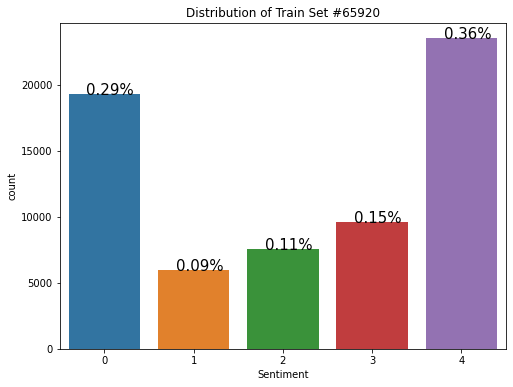

In [11]:
plt.figure(figsize=(8, 6))
plt.title("Distribution of Train Set #%.f" %len(train))
ax=sns.countplot(x="Sentiment", data=train)

for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()/len(train)), (p.get_x()+0.2, p.get_height()),fontsize=15)

In [12]:
train.Sentiment.value_counts()

4    23541
0    19278
3     9597
2     7555
1     5949
Name: Sentiment, dtype: int64

In [13]:
train.shape

(65920, 3)

In [14]:
train['Sentiment'].unique()

array([2, 4, 1, 3, 0])

# Tokenizer

In [0]:
sentences = train.Phrase.values                                                 # .values: Return a Numpy representation of the DataFrame
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]          #BERT를 원활히 사용하기 위해 special token 앞 뒤에 추가
labels = train.Sentiment.values

In [16]:
sentences

['[CLS] The app is great and works well on my device. Love the download option so one never has to miss out on what they are watching. However it seems as if there is a dark filter on some series & movies. Many of the series are also quite backward in seasons in the South African region. Lastly, just as the...Full Review [SEP]',
 "[CLS] I think this app is great. I can always find something new to watch that isn't aired on TV. Sometimes you will find that a show or movie you are looking for is not on Netflix but if you email the company and request for that show or that kind of show to be added, eventually you will see it pop up. P...Full Review [SEP]",
 "[CLS] You should not be able to access account settings from this app. At the very least it should ask you to login once it's opened the browser page but as it is it's really insecure. 2 factor authentication should be required when logging in from a new device. I can't believe that an app this popular fr...Full Review [SEP]",
 '[CLS]

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  # uncased는 do_lower_case = True; corpus의 대문자를 소문자로 바꿀지를 결정하는 옵션
                                                                                    
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]              #각 문장별 tokenize
print ("첫문장 Tokenize\n")
print (train.Phrase[0])
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 929030.20B/s]


첫문장 Tokenize

The app is great and works well on my device. Love the download option so one never has to miss out on what they are watching. However it seems as if there is a dark filter on some series & movies. Many of the series are also quite backward in seasons in the South African region. Lastly, just as the...Full Review
['[CLS]', 'the', 'app', 'is', 'great', 'and', 'works', 'well', 'on', 'my', 'device', '.', 'love', 'the', 'download', 'option', 'so', 'one', 'never', 'has', 'to', 'miss', 'out', 'on', 'what', 'they', 'are', 'watching', '.', 'however', 'it', 'seems', 'as', 'if', 'there', 'is', 'a', 'dark', 'filter', 'on', 'some', 'series', '&', 'movies', '.', 'many', 'of', 'the', 'series', 'are', 'also', 'quite', 'backward', 'in', 'seasons', 'in', 'the', 'south', 'african', 'region', '.', 'lastly', ',', 'just', 'as', 'the', '.', '.', '.', 'full', 'review', '[SEP]']


In [18]:
tokenized_texts  # sentences는 단일list였는데, tokenized_texts는 이중list가 되었네

[['[CLS]',
  'the',
  'app',
  'is',
  'great',
  'and',
  'works',
  'well',
  'on',
  'my',
  'device',
  '.',
  'love',
  'the',
  'download',
  'option',
  'so',
  'one',
  'never',
  'has',
  'to',
  'miss',
  'out',
  'on',
  'what',
  'they',
  'are',
  'watching',
  '.',
  'however',
  'it',
  'seems',
  'as',
  'if',
  'there',
  'is',
  'a',
  'dark',
  'filter',
  'on',
  'some',
  'series',
  '&',
  'movies',
  '.',
  'many',
  'of',
  'the',
  'series',
  'are',
  'also',
  'quite',
  'backward',
  'in',
  'seasons',
  'in',
  'the',
  'south',
  'african',
  'region',
  '.',
  'lastly',
  ',',
  'just',
  'as',
  'the',
  '.',
  '.',
  '.',
  'full',
  'review',
  '[SEP]'],
 ['[CLS]',
  'i',
  'think',
  'this',
  'app',
  'is',
  'great',
  '.',
  'i',
  'can',
  'always',
  'find',
  'something',
  'new',
  'to',
  'watch',
  'that',
  'isn',
  "'",
  't',
  'aired',
  'on',
  'tv',
  '.',
  'sometimes',
  'you',
  'will',
  'find',
  'that',
  'a',
  'show',
  'or',
  

In [0]:
len_list = []
for tokenized_text in tokenized_texts:                                          
  len_list.append(len(tokenized_text))

In [20]:
len_list

[72,
 76,
 75,
 75,
 67,
 80,
 89,
 80,
 79,
 63,
 59,
 65,
 88,
 73,
 100,
 78,
 75,
 69,
 72,
 72,
 78,
 58,
 61,
 74,
 75,
 55,
 73,
 82,
 56,
 70,
 73,
 54,
 75,
 70,
 70,
 80,
 53,
 74,
 81,
 69,
 74,
 71,
 76,
 83,
 59,
 82,
 77,
 72,
 70,
 69,
 53,
 70,
 67,
 78,
 81,
 74,
 68,
 90,
 50,
 67,
 59,
 74,
 69,
 71,
 71,
 73,
 64,
 83,
 80,
 87,
 81,
 72,
 70,
 53,
 80,
 69,
 69,
 79,
 83,
 68,
 60,
 67,
 75,
 77,
 72,
 75,
 78,
 56,
 65,
 90,
 83,
 69,
 72,
 76,
 73,
 67,
 60,
 77,
 83,
 70,
 71,
 75,
 75,
 68,
 75,
 82,
 71,
 87,
 78,
 66,
 76,
 63,
 59,
 54,
 65,
 59,
 68,
 68,
 59,
 79,
 66,
 75,
 68,
 75,
 66,
 88,
 60,
 82,
 75,
 72,
 82,
 54,
 73,
 72,
 76,
 77,
 67,
 75,
 69,
 59,
 84,
 69,
 66,
 78,
 69,
 59,
 80,
 57,
 75,
 80,
 63,
 83,
 53,
 91,
 51,
 61,
 83,
 68,
 67,
 49,
 69,
 53,
 80,
 52,
 73,
 79,
 66,
 68,
 66,
 66,
 58,
 72,
 59,
 74,
 59,
 68,
 51,
 76,
 58,
 40,
 70,
 78,
 54,
 52,
 69,
 65,
 67,
 79,
 66,
 71,
 62,
 87,
 45,
 66,
 74,
 76,
 83,
 61,
 55,
 75,

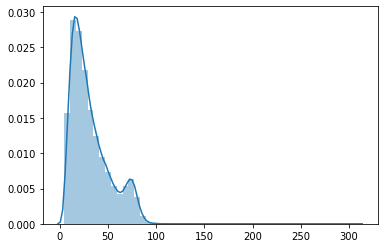

In [21]:
sns.distplot(len_list)

In [22]:
# 토큰 길이 64 넘어가는 것 개수: 7022개, 128을 넘어가는 것은 11개임
cnt = 0
for tokenized_text in tokenized_texts:                                          
  if len(tokenized_text) > 64:
    cnt = cnt + 1

cnt

7022

In [23]:
# 가장 긴 문장의 토큰 개수
longest_len = 0
for tokenized_text in tokenized_texts:                                          
  if len(tokenized_text) > longest_len:
    longest_len = len(tokenized_text)

longest_len

307

In [0]:
# 우리는 최대 토큰 수를 64개로 할 것임. 버트 논문에서는 512개로 했음.
MAX_LEN = 64                                                                    #64보다 벗어난 리뷰 길이 편집 후 special token 붙이기
length_edit=[]
for tokenized_text in tokenized_texts:
  if len(tokenized_text) >MAX_LEN-1:
    cut=tokenized_text[:MAX_LEN-1]
    cut.append(tokenized_text[-1])
    length_edit.append(cut)
  else:
    length_edit.append(tokenized_text)
tokenized_texts = length_edit

In [25]:
tokenized_texts

[['[CLS]',
  'the',
  'app',
  'is',
  'great',
  'and',
  'works',
  'well',
  'on',
  'my',
  'device',
  '.',
  'love',
  'the',
  'download',
  'option',
  'so',
  'one',
  'never',
  'has',
  'to',
  'miss',
  'out',
  'on',
  'what',
  'they',
  'are',
  'watching',
  '.',
  'however',
  'it',
  'seems',
  'as',
  'if',
  'there',
  'is',
  'a',
  'dark',
  'filter',
  'on',
  'some',
  'series',
  '&',
  'movies',
  '.',
  'many',
  'of',
  'the',
  'series',
  'are',
  'also',
  'quite',
  'backward',
  'in',
  'seasons',
  'in',
  'the',
  'south',
  'african',
  'region',
  '.',
  'lastly',
  ',',
  '[SEP]'],
 ['[CLS]',
  'i',
  'think',
  'this',
  'app',
  'is',
  'great',
  '.',
  'i',
  'can',
  'always',
  'find',
  'something',
  'new',
  'to',
  'watch',
  'that',
  'isn',
  "'",
  't',
  'aired',
  'on',
  'tv',
  '.',
  'sometimes',
  'you',
  'will',
  'find',
  'that',
  'a',
  'show',
  'or',
  'movie',
  'you',
  'are',
  'looking',
  'for',
  'is',
  'not',
  'o

In [0]:
len_list = []
for tokenized_text in tokenized_texts:                                          
  len_list.append(len(tokenized_text))

In [27]:
len_list

[64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 63,
 59,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 58,
 61,
 64,
 64,
 55,
 64,
 64,
 56,
 64,
 64,
 54,
 64,
 64,
 64,
 64,
 53,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 59,
 64,
 64,
 64,
 64,
 64,
 53,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 50,
 64,
 59,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 53,
 64,
 64,
 64,
 64,
 64,
 64,
 60,
 64,
 64,
 64,
 64,
 64,
 64,
 56,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 60,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 63,
 59,
 54,
 64,
 59,
 64,
 64,
 59,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 60,
 64,
 64,
 64,
 64,
 54,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 59,
 64,
 64,
 64,
 64,
 64,
 59,
 64,
 57,
 64,
 64,
 63,
 64,
 53,
 64,
 51,
 61,
 64,
 64,
 64,
 49,
 64,
 53,
 64,
 52,
 64,
 64,
 64,
 64,
 64,
 64,
 58,
 64,
 59,
 64,
 59,
 64,
 51,
 64,
 58,
 40,
 64,
 64,
 54,
 52,
 64,
 64,
 64,
 64,
 64,
 64,
 62,
 64,
 45,
 64,
 64,
 64,
 64,
 61,
 55,
 64,


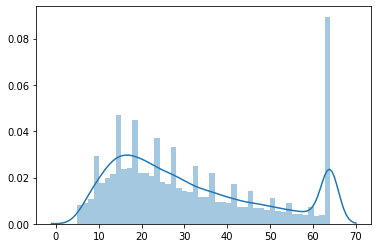

In [28]:
sns.distplot(len_list)

In [29]:
train.Phrase

0        The app is great and works well on my device. ...
1        I think this app is great. I can always find s...
2        You should not be able to access account setti...
3        Love the app. Especially the download feature....
4        I keep having a problem where the screen dimms...
                               ...                        
65915    I love it! High quality videos and great sound...
65916    amazing,best,loads of choice and genres to cho...
65917     It's good but doesn't have that many good movies
65918    Go in the app. Scroll down the app, it freezes...
65919             It is so slow to update the app itself 🙄
Name: Phrase, Length: 65920, dtype: object

In [30]:
len(train.Phrase[0])         # 쓸데없는 지식이긴한데, 유투브는 글자가 300자 넘어가면 ...Full Review로 넘기네

314

In [31]:
len(train.Phrase[0].split())

61

In [32]:
train.Phrase[0].split()

['The',
 'app',
 'is',
 'great',
 'and',
 'works',
 'well',
 'on',
 'my',
 'device.',
 'Love',
 'the',
 'download',
 'option',
 'so',
 'one',
 'never',
 'has',
 'to',
 'miss',
 'out',
 'on',
 'what',
 'they',
 'are',
 'watching.',
 'However',
 'it',
 'seems',
 'as',
 'if',
 'there',
 'is',
 'a',
 'dark',
 'filter',
 'on',
 'some',
 'series',
 '&',
 'movies.',
 'Many',
 'of',
 'the',
 'series',
 'are',
 'also',
 'quite',
 'backward',
 'in',
 'seasons',
 'in',
 'the',
 'South',
 'African',
 'region.',
 'Lastly,',
 'just',
 'as',
 'the...Full',
 'Review']

In [33]:
train.Phrase.apply(lambda x: len(x.split()))

0        61
1        64
2        58
3        58
4        55
         ..
65915    27
65916     8
65917     9
65918    17
65919    10
Name: Phrase, Length: 65920, dtype: int64

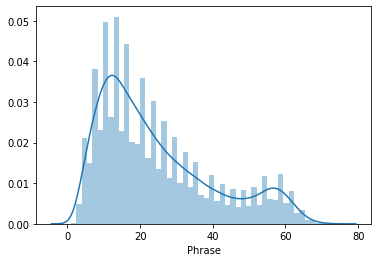

In [34]:
sns.distplot(train.Phrase.apply(lambda x: len(x.split())))                      #띄어쓰기로 나눴을때 그 단어 개수

# Convert tokens to ID & Padding

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],  # pad_sequences는 keras.preprocessing.sequence에서 임포트했음
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [36]:
# 최대 길이 64로 맞춘 tokenize된 문자 상태
tokenized_texts[10]
# 리스트

['[CLS]',
 'awesome',
 ',',
 'joy',
 '##ful',
 ',',
 'and',
 'pleasant',
 '!',
 'netflix',
 'really',
 'did',
 'an',
 'amazing',
 'job',
 'with',
 'their',
 'business',
 '.',
 'i',
 'immediately',
 'got',
 'hooked',
 ',',
 'and',
 'my',
 'favourite',
 'parts',
 'are',
 'where',
 'you',
 'only',
 'need',
 'one',
 'account',
 'for',
 'all',
 'family',
 'members',
 'to',
 'access',
 'separate',
 'users',
 ',',
 'and',
 'the',
 'fact',
 'there',
 'is',
 'unlimited',
 'series',
 'and',
 'films',
 'from',
 'across',
 'the',
 'world',
 '!',
 '[SEP]']

In [37]:
# 토큰들을 ID로 바꾼 후. 단어 → 숫자  ex) [CLS]는 101, [SEP]는 102
tokenizer.convert_tokens_to_ids(tokenized_texts[10])
# 리스트

[101,
 12476,
 1010,
 6569,
 3993,
 1010,
 1998,
 8242,
 999,
 20907,
 2428,
 2106,
 2019,
 6429,
 3105,
 2007,
 2037,
 2449,
 1012,
 1045,
 3202,
 2288,
 13322,
 1010,
 1998,
 2026,
 8837,
 3033,
 2024,
 2073,
 2017,
 2069,
 2342,
 2028,
 4070,
 2005,
 2035,
 2155,
 2372,
 2000,
 3229,
 3584,
 5198,
 1010,
 1998,
 1996,
 2755,
 2045,
 2003,
 14668,
 2186,
 1998,
 3152,
 2013,
 2408,
 1996,
 2088,
 999,
 102]

In [38]:
pad_sequences([tokenizer.convert_tokens_to_ids(tokenized_texts[10])])
# 리스트(list)가 배열(array)가 되었음

array([[  101, 12476,  1010,  6569,  3993,  1010,  1998,  8242,   999,
        20907,  2428,  2106,  2019,  6429,  3105,  2007,  2037,  2449,
         1012,  1045,  3202,  2288, 13322,  1010,  1998,  2026,  8837,
         3033,  2024,  2073,  2017,  2069,  2342,  2028,  4070,  2005,
         2035,  2155,  2372,  2000,  3229,  3584,  5198,  1010,  1998,
         1996,  2755,  2045,  2003, 14668,  2186,  1998,  3152,  2013,
         2408,  1996,  2088,   999,   102]], dtype=int32)

In [39]:
# 패딩 완료
pad_sequences([tokenizer.convert_tokens_to_ids(tokenized_texts[10])],      
                                       maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# 토큰 개수가 64개(maxlen) 넘어가면  그 이후 것 자름(truncating). 그보다 짧으면 다 0으로처리(padding)
# 근데 우린 이미 앞에서 이미 최대 길이 64에 맞게 다 잘라놔서 여기서 추가로 잘리는 것은 없고 길이가 짧은 것들만 패딩됨.

array([[  101, 12476,  1010,  6569,  3993,  1010,  1998,  8242,   999,
        20907,  2428,  2106,  2019,  6429,  3105,  2007,  2037,  2449,
         1012,  1045,  3202,  2288, 13322,  1010,  1998,  2026,  8837,
         3033,  2024,  2073,  2017,  2069,  2342,  2028,  4070,  2005,
         2035,  2155,  2372,  2000,  3229,  3584,  5198,  1010,  1998,
         1996,  2755,  2045,  2003, 14668,  2186,  1998,  3152,  2013,
         2408,  1996,  2088,   999,   102,     0,     0,     0,     0,
            0]])

In [40]:
input_ids

array([[  101,  1996, 10439, ..., 22267,  1010,   102],
       [  101,  1045,  2228, ...,  2776,  2017,   102],
       [  101,  2017,  2323, ...,  1056,  2903,   102],
       ...,
       [  101,  2009,  1005, ...,     0,     0,     0],
       [  101,  2175,  1999, ...,     0,     0,     0],
       [  101,  2009,  2003, ...,     0,     0,     0]])

# Attention Mask

In [0]:
attention_masks = []

for seq in input_ids:                                                           # float(True) = 1.0, float(False) = 0.0
  seq_mask = [float(i>0) for i in seq]                                          #각 데이터에 숫자가 있으면 1 없으면 0 으로 1,0으로 이루어진 벡터로 변환 ex) [50,1,3,0,0,1]→[1,1,1,0,0,1]
  attention_masks.append(seq_mask)                                              #bert에서 모델이 신경쓸 인풋들을 표현하기 위한 인수

# Attention Mask는 padding 된 단어들에 대해 이 모델이 신경을 쓰지 않도록 해주기 위한 용도로만 쓰이는 듯

In [42]:
print(attention_masks[10])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [43]:
attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.

# Train, Validation split

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks, 
                                                            random_state=2020, test_size=0.1)
                                                                                # input_ids: 단어들 tokenize 해서 ID화 시킨것들 
                                                                                # labels: sentiment 지수
                                                                                # attention_masks: 문장에서 단어가 있으면 1 없으면 0 으로 시킨것 
# train_inputs : (59328, 64)
# validation_inputs : (6592, 64)
# train_labels : (59328, )
# validation_labels: (6592, )
# train_masks: list 59328개 items
# validation_masks: list 6592개 items

In [45]:
print("train 데이터 하나 찍어보자")
print("\ntokenizer후 \n",train_inputs[0])                     
print("\n레이팅 라벨 \n", train_labels[0])      
print("\n Attention mask \n", train_masks[0])

train 데이터 하나 찍어보자

tokenizer후 
 [  101  1045  2293 20907  2021  2045  4995  1005  1056  2438  5469  5691
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]

레이팅 라벨 
 4

 Attention mask 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Tensorflow & DataLoader

In [0]:
train_inputs = torch.tensor(train_inputs)                                       #데이터 입력형 변환
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 32                                                                 #일반적으로 16,32 사용
                                                                                #DataLoader 사용함으로써 training 중 전체 데이터를 불러오지 않기에 메모리 절약의 이점이 있음
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)                                       #sampler 는 index를 랜덤하게 가져온다
train_dataloader = DataLoader(train_data, sampler=train_sampler,                #데이터가 크기에 batch size 만큼씩 넣어서 처리함
                              batch_size=batch_size)                            #ex) batch size2로 할시 (train_inputs 2개, train_masks 2개, train_labels 2개)가 한묶음
                                                                                
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler,
                                   batch_size=batch_size)


# Model

In [48]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",      #single linear classification layer가 위에 있는 모델
                                                      num_labels=5)             #분류해야할게 5가지 이기 때문에 num_labels=5
model.cuda()                                                                    #GPU 사용해서 할때 필요한 함수

100%|██████████| 407873900/407873900 [00:14<00:00, 27268535.65B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())                                # 레이어 등등의 pretrained 파라미터 값들
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [                                                # 두가지의 파라미터 그룹으로 나눠짐
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],   # any()는 어느 하나라도 True면 True를 출력.any(True, False, Flase) = True
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [50]:
optimizer = BertAdam(optimizer_grouped_parameters,                              # training에 필요한 모든 hyperparameter들의 정보를 갖고 있음?
                     lr=2e-5,                                                   # lr = 2e-5, 3e-5, 5e-5를 많이 씀.
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [51]:
optimizer

BertAdam (
Parameter Group 0
    b1: 0.9
    b2: 0.999
    e: 1e-06
    lr: 2e-05
    max_grad_norm: 1.0
    schedule: <pytorch_pretrained_bert.optimization.WarmupLinearSchedule object at 0x7f31aaf6e8d0>
    weight_decay: 0.01
    weight_decay_rate: 0.01

Parameter Group 1
    b1: 0.9
    b2: 0.999
    e: 1e-06
    lr: 2e-05
    max_grad_norm: 1.0
    schedule: <pytorch_pretrained_bert.optimization.WarmupLinearSchedule object at 0x7f31aaf6e8d0>
    weight_decay: 0.01
    weight_decay_rate: 0.0
)

In [0]:
def flat_accuracy_mse(preds, labels):                                           #정확도와 mse를 계산하는 함수
    pred_flat = np.argmax(preds, axis=1).flatten()                              #행별로 가장 큰 값의 class를 반환 → 가장 확률 높은 class
    labels_flat = labels.flatten()
    tmp_accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    tmp_mse = mean_squared_error(pred_flat, labels_flat) 
    return tmp_accuracy, tmp_mse                                                #예측값과 라벨값이 같은것들을 전체 데이터수로 평균= accuracy
                                                                                #batch가 있기에 여러개를 한꺼번에 accuracy 계산

# Training

In [53]:
train_loss_set = []                                                             

epochs = 2                                                                      #일반적으로 2,3,4 추천

for _ in trange(epochs, desc="Epoch"):                                          #tqdm: for 문의 진행상황을 보여줌, trange: tqdm 을 활용한 range  이름은 Epoch으로 나옴  
  
  # Training
  
  # 학습모드로 변경
  model.train()                                                                 
  
  # 추적 변수
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):                               #(순서, 값)
    batch = tuple(t.to(device) for t in batch)                                  # batch를 GPU로
    b_input_ids, b_input_mask, b_labels = batch                                 # Dataloader에서 값 끌고오기
    optimizer.zero_grad()                                                       # 이유: https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
    # 순전파
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels) #loss 반환
    train_loss_set.append(loss.item())    
    # 역전파
    loss.backward()
    # 파라미터 업데이트
    optimizer.step()
   
    # 추적 변수 업데이트
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # 평가모드로 변경
  model.eval()

  # 추적 변수
  eval_mse, eval_accuracy = 0, 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:                                           
    predictions = []
    batch = tuple(t.to(device) for t in batch)                                  # batch를 GPU로
    b_input_ids, b_input_mask, b_labels = batch                                 # Dataloader에서 값 끌고오기
    with torch.no_grad():                                                       # gradients 계산하거나 저장하게 하지 않음으로써 메모리 절약과 평가속도 향상
      # 순전파
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask) # 각 class 별 확률을 반환, index가 0~4 = 각 점수
    
    # 나온 값을 CPU로 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy,tmp_eval_mse = flat_accuracy_mse(logits, label_ids)                        
    
    eval_accuracy += tmp_eval_accuracy
    eval_mse += tmp_eval_mse

    nb_eval_steps += 1
    
  print("Validation Accuracy: {}  Validation RMSE: {}".format(eval_accuracy/nb_eval_steps,(eval_mse/nb_eval_steps)**0.5))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.9232322675092578


Epoch:  50%|█████     | 1/2 [09:30<09:30, 570.37s/it]

Validation Accuracy: 0.6535194174757282  Validation RMSE: 1.0677873865674858
Train loss: 0.8058641727977586


Epoch: 100%|██████████| 2/2 [18:59<00:00, 569.81s/it]

Validation Accuracy: 0.6597390776699029  Validation RMSE: 1.0266473856046836


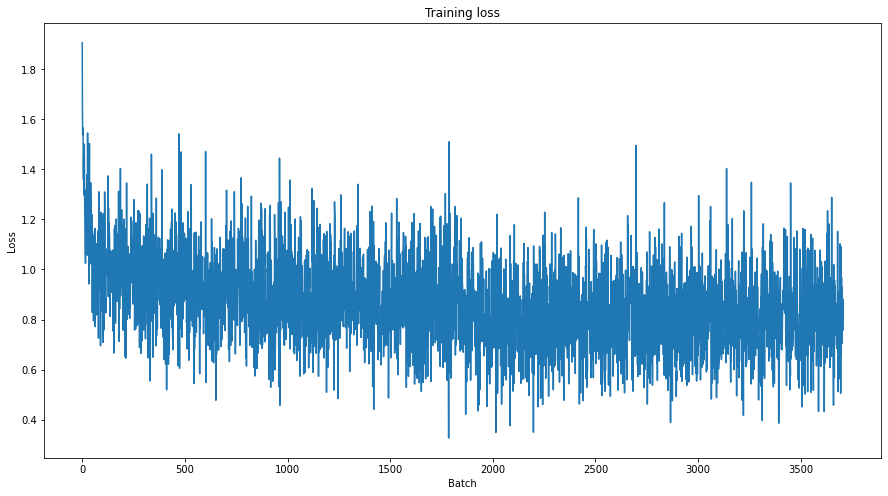

In [54]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

#모델 저장, 불러오기

In [0]:
# torch.save(model.state_dict(),'/content/drive/My Drive/model_netflix_82400_epoch2.pth')

In [68]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",      #원래클래스 지정, 내부 파라미터 같은걸 불러오는것이기에 클래스 지정 안하면 사용 못함
                                                      num_labels=5)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/netflix_review_project/model_netflix_82400_epoch2.pth'))         
model.cuda()                                                                    #GPU 지정 같은 느낌

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

# Test

In [0]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/test_netflix_82400.csv")
test.dropna(inplace=True)
test['Sentiment'] = test.Sentiment.astype(int)-1

test_id = test['SentenceId']
test_phrase = test['Phrase']
labels = test.Sentiment.values

In [70]:
test

SentenceId                                             Phrase  Sentiment
0           65921  Omalekin boru vawe zor narsaykan silaram olina...          4
1           65922  I really like it because you can watch the fil...          4
2           65923  Limited movies. 😠😠 Now netflix made for money ...          0
3           65924  it has only flop movies . Do not buy its subsc...          0
4           65925              it is nice but it takes lot of spacel          3
...           ...                                                ...        ...
16475       82396                            I fricken love this app          4
16476       82397                                   its is very good          3
16477       82398  hey good shows to get would be the 90s kids sh...          4
16478       82399                works good dont have any problems..          4
16479       82400  i love Netflix its perfect to watch your fav e...          4

[16480 rows x 3 columns]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)#이후 트레인때와 같은 방식으로 데이터 처리
sentences = test.Phrase.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [0]:
MAX_LEN = 64
length_edit=[]
for tokenized_text in tokenized_texts:
  if len(tokenized_text) >MAX_LEN-1:
    cut=tokenized_text[:MAX_LEN-1]
    cut.append(tokenized_text[-1])
    length_edit.append(cut)
  else:
    length_edit.append(tokenized_text)
tokenized_texts=length_edit

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

In [0]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

In [0]:
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)                         #순차적으로 인덱스 샘플해서 출력, Randomsampler 와 다른건 TEST셋을 순서대로 평가하기 위해
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# 평가 모드로 전환
model.eval()

# 추적 변수 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)                                    # batch를 GPU로
  
  b_input_ids, b_input_mask, b_labels = batch                                   # Dataloader에서 값 끌고오기
  with torch.no_grad():                                                         # gradients 계산하거나 저장하게 하지 않음으로써 메모리 절약과 평가속도 향상
    # 순전파
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # 나온 값을 CPU로 이동
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # 예측확률값 저장
  predictions.append(logits)                           

In [0]:
preds = np.concatenate(predictions)                                             #32개씩 한꺼번에 묶여있는 값들 합치기
pred_labels = np.argmax(preds, axis =1)                                         #가장 class 확률이 높은 것의 index= 점수

In [78]:
submission = pd.DataFrame({'PhraseId': test_id, 'Phrase': test_phrase, 'Pred_Sentiment': pred_labels,'Real_Sentiment':labels})
submission.to_csv('/content/drive/My Drive/submission_netflix.csv', index=False)
submission.head(10)

PhraseId  ... Real_Sentiment
0     65921  ...              4
1     65922  ...              4
2     65923  ...              0
3     65924  ...              0
4     65925  ...              3
5     65926  ...              1
6     65927  ...              0
7     65928  ...              3
8     65929  ...              4
9     65930  ...              4

[10 rows x 4 columns]

In [79]:
print("모델의 정확도 :%.6f\n모델의 RMSE :%.6f" %(accuracy_score(pred_labels, labels),mean_squared_error(pred_labels, labels)**0.5))

모델의 정확도 :0.734709
모델의 RMSE :1.045680


Normalized confusion matrix


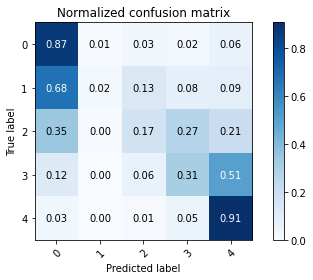

In [80]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):

    title ='Normalized confusion matrix'
    cm = confusion_matrix(y_true, y_pred)    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
               ax.text(j, i, format(cm[i, j], fmt),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(labels, pred_labels, classes=[0, 1, 2, 3, 4])

# WORD CLOUD

In [81]:
!pip install wordcloud

In [0]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image

In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/train_netflix_82400.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/test_netflix_82400.csv")

train.dropna(inplace=True)
test.dropna(inplace=True)
train['Sentiment'] = train.Sentiment.astype(int)-1
test['Sentiment'] = test.Sentiment.astype(int)-1

submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/netflix_review_project/submission_netflix.csv")

In [84]:
train.head()

SentenceId                                             Phrase  Sentiment
0           1  The app is great and works well on my device. ...          2
1           2  I think this app is great. I can always find s...          4
2           3  You should not be able to access account setti...          1
3           4  Love the app. Especially the download feature....          3
4           5  I keep having a problem where the screen dimms...          2

# Data Cleaning

In [0]:
train['Phrase'] = train['Phrase'].str.lower()
test['Phrase'] = test['Phrase'].str.lower()
submission['Phrase'] = submission['Phrase'].str.lower()

In [92]:
import re

words = ['watch','netflix','love', 'movie','movies', 'good', 'hate','gets','show', 'hey','great','app','find', 'full', 'one', 'want', 'will']

def remove_word(text,word_to_remove):
    word = re.compile(word_to_remove)       # re.compile(검색할문자열) 와 같이 함수를 호출하면 정규식 객체 (re.RegexObject 클래스 객체)를 리턴하게 된다.
    return word.sub('', text)               # word.sub('', text): text에서 word가 ''로 교체됨 

text = "I watch netflix"
for word in words:
    text = remove_word(text, word)
print(text)

I  


In [93]:
text = "i watch netflix"
a = re.compile('watch')
a.sub('', text)

'i  netflix'

In [0]:
for word in words:
    train['Phrase']=train['Phrase'].apply(lambda x: remove_word(x, word))

for word in words:
    test['Phrase']=test['Phrase'].apply(lambda x: remove_word(x, word))

for word in words:
    submission['Phrase']=submission['Phrase'].apply(lambda x: remove_word(x, word))

In [96]:
train.head()

SentenceId                                             Phrase  Sentiment
0           1  the  is  and works well on my device.  the dow...          2
1           2  i think this  is . i can always  something new...          4
2           3  you should not be able to access account setti...          1
3           4   the . especially the download feature. i can ...          3
4           5  i keep having a problem where the screen dimms...          2

## Train 셋의 word cloud 분포

In [0]:
high_rate_review = train[train['Sentiment'] >2]['Phrase']
high_rating_document = high_rate_review.values

low_rate_review = train[train['Sentiment'] <2]['Phrase']
low_rating_document = low_rate_review.values

In [98]:
high_rate_review

1        i think this  is . i can always  something new...
3         the . especially the download feature. i can ...
6         i  this .... it's only that you  what  s you ...
10       awesome, joyful, and pleasant!  really did an ...
13        and chill, as t say! but, this  is very  for ...
                               ...                        
65909                   always a  selection to choose from
65911    t took off courage the cowardly dog! ;-; a lon...
65915    i  it! high quality videos and  sound amazing ...
65916    amazing,best,loads of choice and genres to cho...
65917                  it's  but doesn't have that many  s
Name: Phrase, Length: 33138, dtype: object

In [99]:
high_rating_document

array(["i think this  is . i can always  something new to  that isn't aired on tv. sometimes you   that a  or  you are looking for is not on  but if you email the company and request for that  or that kind of  to be added, eventually you  see it pop up. p... review",
       ' the . especially the download feature. i can  my favorite s and series on the road! also when there is no internet!!! it is so easy to make an account. the only thing that can be better is the subtitles.  than more timez the subtitles have random words that are not what the char... review',
       " i  this .... it's only that you  what  s you to ..... because when i search for the  i  i get other s and i seem not  the  i .... so am left with no choice but to take a look at the s listed and   suitable for me to .... i j... review",
       ...,
       'i  it! high quality videos and  sound amazing s and s!♡  question when does riverdale season 4 go out to  in anchorage alaska??',
       'amazing,best,loads of choic

Text(0.5, 1.0, 'Low rate review')

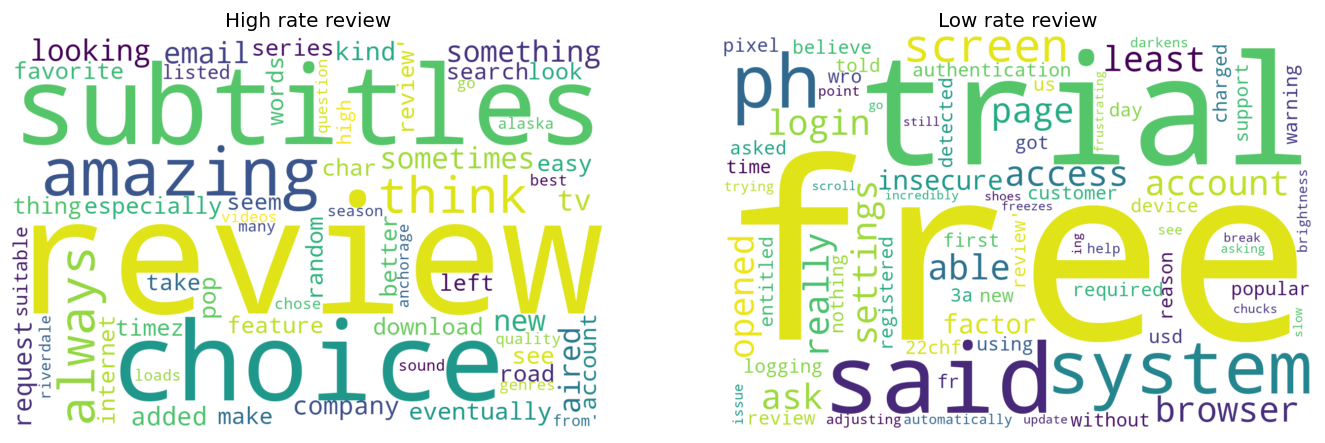

In [100]:
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(high_rating_document))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(low_rating_document))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(121)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("High rate review")

plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("Low rate review")

## Test 셋의 word cloud 분포

In [0]:
high_rate_review = test[test['Sentiment'] >2]['Phrase']
high_rating_document = high_rate_review.values

low_rate_review = test[test['Sentiment'] <2]['Phrase']
low_rating_document = low_rate_review.values

Text(0.5, 1.0, 'Low rate review')

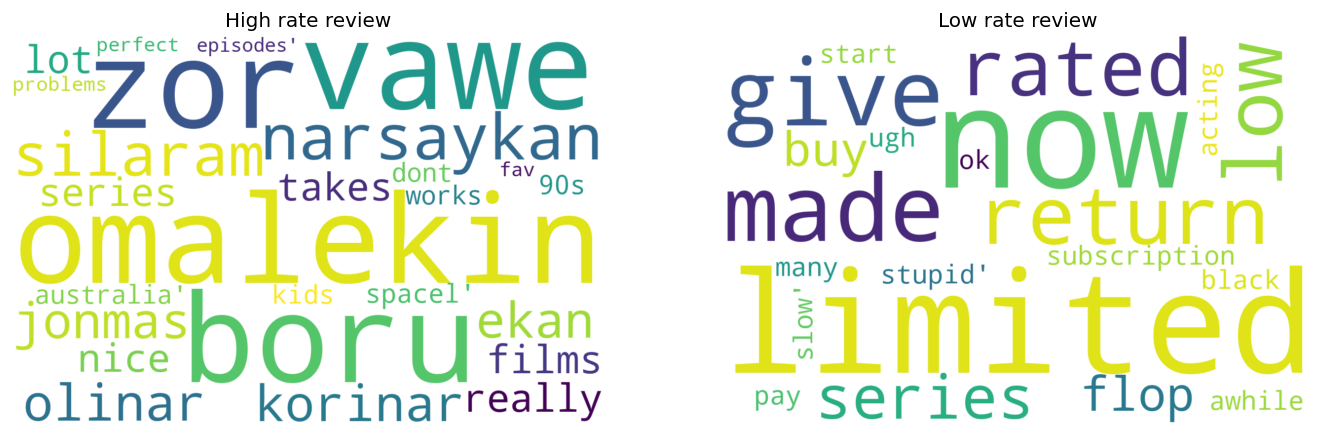

In [102]:
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(high_rating_document))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(low_rating_document))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(121)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("High rate review")

plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("Low rate review")

# Test_real_0, 1, 2, 3, 4 따로

In [0]:
rate_review_test0 = submission[submission['Real_Sentiment'] == 0]['Phrase']
rating_document_test0 = rate_review_test0.values

rate_review_test1 = submission[submission['Real_Sentiment'] == 1]['Phrase']
rating_document_test1 = rate_review_test1.values

rate_review_test2 = submission[submission['Real_Sentiment'] == 2]['Phrase']
rating_document_test2 = rate_review_test2.values

rate_review_test3 = submission[submission['Real_Sentiment'] == 3]['Phrase']
rating_document_test3 = rate_review_test3.values

rate_review_test4 = submission[submission['Real_Sentiment'] == 4]['Phrase']
rating_document_test4 = rate_review_test4.values

Text(0.5, 1.0, "sentiment '4' review")

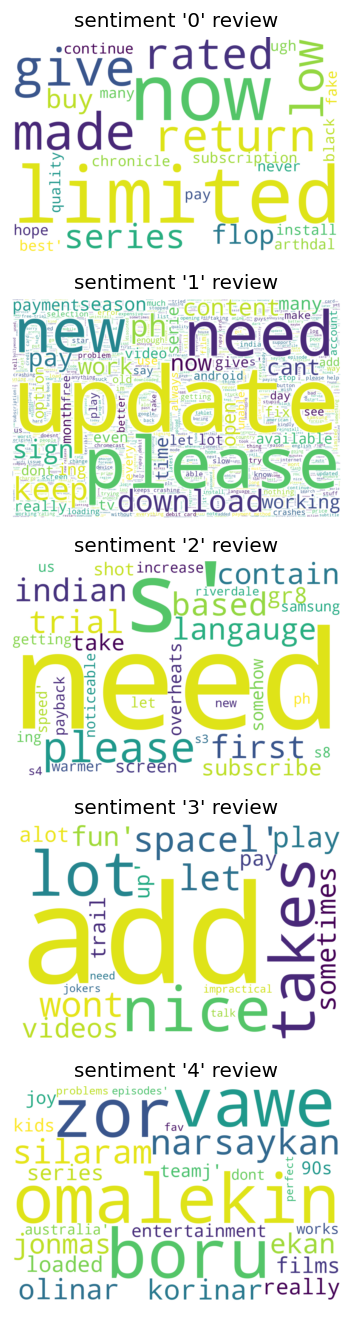

In [111]:
wc0 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_test0))
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_test1))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_test2))
wc3 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_test3))
wc4 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_test4))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(511)
plt.imshow(wc0, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '0' review")

plt.subplot(512)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '1' review")

plt.subplot(513)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '2' review")

plt.subplot(514)
plt.imshow(wc3, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '3' review")

plt.subplot(515)
plt.imshow(wc4, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '4' review")

## Test 셋으로 예측한 word cloud 분포

In [0]:
high_rate_review = submission[submission['Pred_Sentiment'] >2]['Phrase']
high_rating_document = high_rate_review.values

low_rate_review = submission[submission['Pred_Sentiment'] <2]['Phrase']
low_rating_document = low_rate_review.values

Text(0.5, 1.0, 'Low rate review')

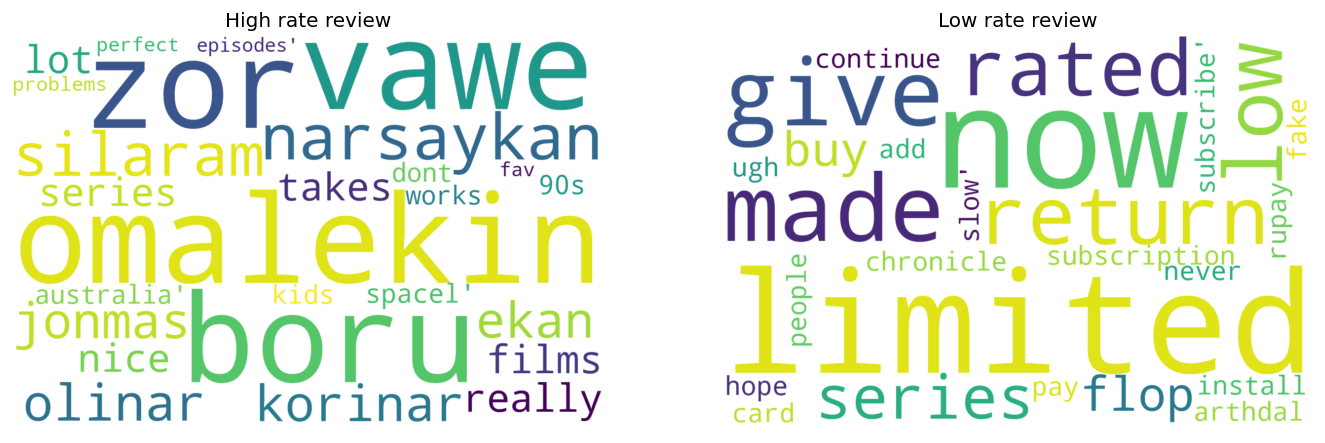

In [110]:
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(high_rating_document))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=2000,random_state=100).generate(np.array2string(low_rating_document))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(121)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("High rate review")

plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("Low rate review")

# Test_pred_0, 1, 2, 3, 4 따로

In [0]:
rate_review_testpred0 = submission[submission['Pred_Sentiment'] == 0]['Phrase']
rating_document_testpred0 = rate_review_testpred0.values

rate_review_testpred1 = submission[submission['Pred_Sentiment'] == 1]['Phrase']
rating_document_testpred1 = rate_review_testpred1.values

rate_review_testpred2 = submission[submission['Pred_Sentiment'] == 2]['Phrase']
rating_document_testpred2 = rate_review_testpred2.values

rate_review_testpred3 = submission[submission['Pred_Sentiment'] == 3]['Phrase']
rating_document_testpred3 = rate_review_testpred3.values

rate_review_testpred4 = submission[submission['Pred_Sentiment'] == 4]['Phrase']
rating_document_testpred4 = rate_review_testpred4.values

Text(0.5, 1.0, "sentiment '4' review")

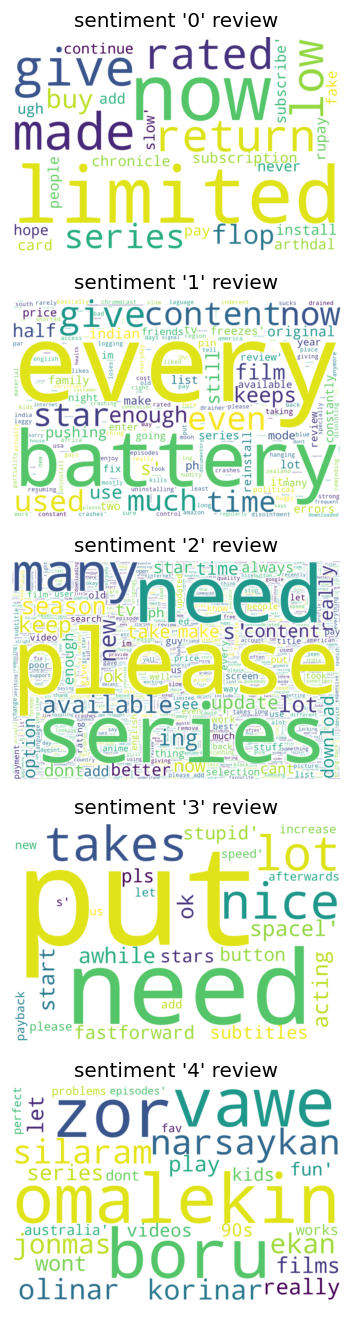

In [114]:
wc0 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_testpred0))
wc1 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_testpred1))
wc2 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_testpred2))
wc3 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_testpred3))
wc4 = WordCloud(width = 1200, height = 800, background_color="white",max_font_size=500,max_words=3000,random_state=100).generate(np.array2string(rating_document_testpred4))

plt.figure(figsize=(14,14),dpi=120)

plt.subplot(511)
plt.imshow(wc0, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '0' review")

plt.subplot(512)
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '1' review")

plt.subplot(513)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '2' review")

plt.subplot(514)
plt.imshow(wc3, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '3' review")

plt.subplot(515)
plt.imshow(wc4, interpolation='bilinear')
plt.axis("off")
plt.title("sentiment '4' review")